# Detailed example of an entry being de-identified of PII and processed through a LLM Model

## Required imports

In [1]:
import json #pip install jsonschema=4.17.3
import openai #pip install openai==1.2.0
import pandas as pd
import numpy as np
from azure.ai.textanalytics import TextAnalyticsClient, PiiEntityCategory #pip install azure-ai-textanalytics==5.2.0
from azure.core.credentials import AzureKeyCredential #pip install azure-core
from tqdm import tqdm #for progress bar

## Get and set configuration values

In [2]:
with open(r'config.json') as config_file:
    config_details = json.load(config_file)
config_file.close()    

# Azure AI Language service configuration
key = config_details['AZURE_LANG_SVC_KEY']
endpoint = config_details['AZURE_LANG_SVC_ENDPT']

# Azure OpenAI configuration
openai.api_type = "azure"
openai.api_base = config_details['OPENAI_API_BASE']
openai.api_version = config_details['OPENAI_API_VERSION']
openai.api_key = config_details['OPENAI_API_KEY']

## Set up some helper methods

### Authentication for Azure Service

In [3]:
# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=endpoint, 
            credential=ta_credential)
    return text_analytics_client

### Method to filter by confidence level

In [4]:
# Utility method to implement a confidence level filter
def filter_confidence_level(target_text, entity_data, confidence_level=0.8):

    updated_text = target_text
    for entity in entity_data:
        if entity.confidence_score < confidence_level:
            updated_text = updated_text[:entity.offset] + entity.text + updated_text[entity.offset+entity.length:]
    return updated_text        

## Method to deidentify and classify notes

### PiiEntityCategory list: https://learn.microsoft.com/en-us/python/api/azure-ai-textanalytics/azure.ai.textanalytics.piientitycategory?view=azure-python

In [5]:
# Create a method to process a collection of notes
def process_notes_entry(text_analytics_client, notes, debug=False):
    
    formatted_result = []
    
    # List types of PII to remove from text
    categories_filter = [
          PiiEntityCategory.PHONE_NUMBER,
          PiiEntityCategory.ADDRESS,
          PiiEntityCategory.PERSON] 
    
    response = text_analytics_client.recognize_pii_entities(notes, 
                                                            categories_filter=categories_filter, language="en")

    result = [doc for doc in response if not doc.is_error]
    for i, doc in enumerate(result):
        if (debug):
            print("========================")
        first_entityPerson = ""
        for entity in doc.entities:
            if first_entityPerson == "" and entity.category == "Person":
                first_entityPerson = entity.text
            if (debug):    
                print(f"Entity: {entity.text}")
                print(f"\tCategory: {entity.category}")
                print(f"\tConfidence Score: {entity.confidence_score}")
                print(f"\tOffset: {entity.offset}")
                print(f"\tLength: {entity.length}")
        
        app_confid_text = filter_confidence_level(doc.redacted_text, doc.entities, confidence_level=0.8)
        if (debug):
            print(f"Redacted Text at confidence_level >= 0.8: {app_confid_text}")
            print("========================")
                   
        prompt_val_1shot = f"""
            Pretend you are Santa Claus and tell me if the child described below belongs on the
            Nice or Naughty list for this Christmas. Be sure to take into account the relative impact
            and severity of the each of the behaviors described. You may only answer with 'Nice' or 'Naughty' 
            for your response. Do not always say 'Nice' 
            Name: ********** | 6 years | ****************************** | ************
            Notes: ***** frequently lied about finishing his homework, bullied classmates, and was unkind to his pets. 
            Answer: Naughty
            {app_confid_text} 
            Answer:"""
        
          
        responseAI = openai.Completion.create(
            engine="brio-davinci3",
            #engine="brio-gpt35",
            prompt=prompt_val_1shot,
            temperature=0.1,
            max_tokens=3,
            top_p=0.1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=None)   
        
        if (debug):
            print(responseAI)
        
        # Take the first line of the original text and append the result
        formatted_result.append(notes[i].split('\n')[0] + " | " + responseAI['choices'][0]['text'].strip().upper())
           
    return formatted_result

## Authenticate and try it out!

In [6]:
txt_analytics = authenticate_client()

## Sample 1

In [7]:
sample_note_1 = """Timmy Johnson | 7 years | 123 Main St, Pleasant PA 19305| 345-555-4433

Notes: Timmy's had an ok year. He's doing better in school and mostly stopped pulling the dog’s tail. However, he's 
fallen in with a bit of a bad crowd and started pushing crypto schemes on his classmates.  He convinced them to invest 
their lunch money in his new 'TimmyCoin2.0' and then told them it lost all its value when they tried to cash out. He's 
also begun selling NFTs of his drawings, insisting they will only go up in value.
"""

output = process_notes_entry(text_analytics_client=txt_analytics,
                            notes=[sample_note_1], debug=True)

print(output)

Entity: Timmy Johnson
	Category: Person
	Confidence Score: 1.0
	Offset: 0
	Length: 13
Entity: 123 Main St, Pleasant PA 19305
	Category: Address
	Confidence Score: 1.0
	Offset: 26
	Length: 30
Entity: 345-555-4433
	Category: PhoneNumber
	Confidence Score: 0.8
	Offset: 58
	Length: 12
Entity: Timmy
	Category: Person
	Confidence Score: 0.99
	Offset: 79
	Length: 5
Redacted Text at confidence_level >= 0.8: ************* | 7 years | ******************************| ************

Notes: *****'s had an ok year. He's doing better in school and mostly stopped pulling the dog’s tail. However, he's 
fallen in with a bit of a bad crowd and started pushing crypto schemes on his classmates.  He convinced them to invest 
their lunch money in his new 'TimmyCoin2.0' and then told them it lost all its value when they tried to cash out. He's 
also begun selling NFTs of his drawings, insisting they will only go up in value.

{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logpro

## Sample 2

In [8]:
sample_note_2 = """Flora McJingles | 9 years | 123 Holly Lane, North Pole 00000 | 123-555-7890

Notes: Flora has shown exceptional kindness by helping her friends with their homework and sharing her toys generously. 
She participated in community clean-up events and volunteered at the local elf workshop during the holidays. Flora also 
displayed creativity by organizing a snowman-building contest for her neighborhood, spreading joy among her peers. On the 
flip side, she was caught attempting to teach the reindeer how to dance the salsa and was found exchanging her vegetables 
for cookies in the school cafeteria. Flora's adventurous spirit led her to embark on a daring mission to retrieve lost 
presents from the workshop, demonstrating her determination.
"""

output = process_notes_entry(text_analytics_client=txt_analytics,
                            notes=[sample_note_2], debug=True)

print(output)

Entity: Flora McJingles
	Category: Person
	Confidence Score: 0.99
	Offset: 0
	Length: 15
Entity: 123 Holly Lane, North Pole 00000
	Category: Address
	Confidence Score: 1.0
	Offset: 28
	Length: 32
Entity: 123-555-7890
	Category: PhoneNumber
	Confidence Score: 0.8
	Offset: 63
	Length: 12
Entity: Flora
	Category: Person
	Confidence Score: 0.98
	Offset: 84
	Length: 5
Entity: Flora
	Category: Person
	Confidence Score: 1.0
	Offset: 602
	Length: 5
Redacted Text at confidence_level >= 0.8: *************** | 9 years | ******************************** | ************

Notes: ***** has shown exceptional kindness by helping her friends with their homework and sharing her toys generously. 
She participated in community clean-up events and volunteered at the local elf workshop during the holidays. Flora also 
displayed creativity by organizing a snowman-building contest for her neighborhood, spreading joy among her peers. On the 
flip side, she was caught attempting to teach the reindeer how to dance

## Sample 3

In [9]:
sample_note_3 = """Ollie Oops | 6 years | 123 Mishap Street, Oopsburg, OB 12345 | 901-555-5678

Notes: Ollie occasionally had oops-themed tea parties with imaginary friends, apologized for accidentally turning 
the living room into a slip 'n slide with spilled juice, consistently shared band-aids with friends, helped organize 
a funny fall contest, had a small disagreement about the best pratfall with a classmate, donated bubble wrap 
to a local charity, occasionally argued with parents about spill prevention, helped set up a clumsy obstacle course 
for neighbors, and shared band-aid-shaped cookies with classmates.
"""

output = process_notes_entry(text_analytics_client=txt_analytics,
                            notes=[sample_note_3], debug=True)

print(output)

Entity: Ollie
	Category: Person
	Confidence Score: 0.75
	Offset: 0
	Length: 5
Entity: 123 Mishap Street, Oopsburg, OB 12345
	Category: Address
	Confidence Score: 1.0
	Offset: 23
	Length: 37
Entity: 901-555-5678
	Category: PhoneNumber
	Confidence Score: 0.8
	Offset: 63
	Length: 12
Entity: Ollie
	Category: Person
	Confidence Score: 1.0
	Offset: 84
	Length: 5
Redacted Text at confidence_level >= 0.8: Ollie Oops | 6 years | ************************************* | ************

Notes: ***** occasionally had oops-themed tea parties with imaginary friends, apologized for accidentally turning 
the living room into a slip 'n slide with spilled juice, consistently shared band-aids with friends, helped organize 
a funny fall contest, had a small disagreement about the best pratfall with a classmate, donated bubble wrap 
to a local charity, occasionally argued with parents about spill prevention, helped set up a clumsy obstacle course 
for neighbors, and shared band-aid-shaped cookies with classma

# Test with Azure Sentiment Analysis

In [10]:
# Test sentiment
documents = [sample_note_1, sample_note_2, sample_note_3]
sentiment_result = txt_analytics.analyze_sentiment(documents)
docs = [doc for doc in sentiment_result if not doc.is_error]

for idx, doc in enumerate(docs):
    print("========================")
    print(f"Document text: {documents[idx]}")
    print(f"Overall sentiment: {doc.sentiment}")
    print(f"Sentiment confidence scores: {doc.confidence_scores}")

Document text: Timmy Johnson | 7 years | 123 Main St, Pleasant PA 19305| 345-555-4433

Notes: Timmy's had an ok year. He's doing better in school and mostly stopped pulling the dog’s tail. However, he's 
fallen in with a bit of a bad crowd and started pushing crypto schemes on his classmates.  He convinced them to invest 
their lunch money in his new 'TimmyCoin2.0' and then told them it lost all its value when they tried to cash out. He's 
also begun selling NFTs of his drawings, insisting they will only go up in value.

Overall sentiment: mixed
Sentiment confidence scores: {'positive': 0.24, 'neutral': 0.17, 'negative': 0.59}
Document text: Flora McJingles | 9 years | 123 Holly Lane, North Pole 00000 | 123-555-7890

Notes: Flora has shown exceptional kindness by helping her friends with their homework and sharing her toys generously. 
She participated in community clean-up events and volunteered at the local elf workshop during the holidays. Flora also 
displayed creativity by organiz

## Process a larger list from a file

In [11]:
class Style():
  RED = "\033[31m"
  GREEN = "\033[1;32m"
  RESET = "\033[0m"

output = []
result = []
pbar = tqdm(total=27, colour="green")

with open('santas_notes.txt', 'rt') as notes_file:
    notes_list = []
    output = []
    for b in notes_file:
        if b.startswith("Name:"):
            current_child = b
        if b.startswith("Notes:"):
            current_child += b
            notes_list.append(current_child)
        if len(notes_list) == 5:
            output.extend(process_notes_entry(text_analytics_client=txt_analytics,
                            notes=notes_list, debug=False))
            notes_list = [] 
            pbar.update(5)
    if len(notes_list) > 0:
        output.extend(process_notes_entry(text_analytics_client=txt_analytics,
                        notes=notes_list, debug=False))
        pbar.update(len(notes_list))
pbar.close()


        
for doc in output:
    if "NICE" in doc:
        print(f"{Style.GREEN}{doc}{Style.RESET}")
        result.append('Nice')
    else:
        print(f"{Style.RED}{doc}{Style.RESET}")    
        result.append('Naughty')
            
df = pd.DataFrame(result, columns=['result'])

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.14it/s]

Name: Timmy Johnson | 7 years | 123 Main St, Pleasant PA 19305| 345-555-4433 | NAUGHTY
Name: Flora McJingles | 9 years | 123 Holly Lane, North Pole 00000 | 123-555-7890 | NICE
Name: Ollie Oops | 6 years | 123 Mishap Street, Oopsburg, OB 12345 | 901-555-5678 | NICE
Name: Wendy Whirlwind | 6 years | 456 Tornado Terrace, Gale City, GC 45678 | 123-555-6789 | NICE
Name: Milo Mischief | 8 years | 789 Prankster Lane, Jesterville, JV 78901 | 234-555-8901 | NICE
Name: Lily Martinez | 5 years | 789 Mistletoe Avenue, Hollyville, HV 78901 | 901-555-5678 | NICE
Name: Caleb Miller | 11 years | 210 Reindeer Road, Sleighville, SV 18940 | 210-555-3456 | NAUGHTY
Name: Candace Flynn | 14 years | 123 Bustable Blvd, Danville 23456 | 123-555-4567 | NAUGHTY
Name: Isabella Garcia-Shapiro | 9 years | 789 Fireside Lane, Danville 23456 | 345-555-6789 | NICE
Name: Baljeet Tjinder | 12 years | 202 Smarty Lane, Danville 23456 | 567-555-8901 | NICE
Name: Buford Van Stomm | 11 years | 101 Tough Street, Danville 23456

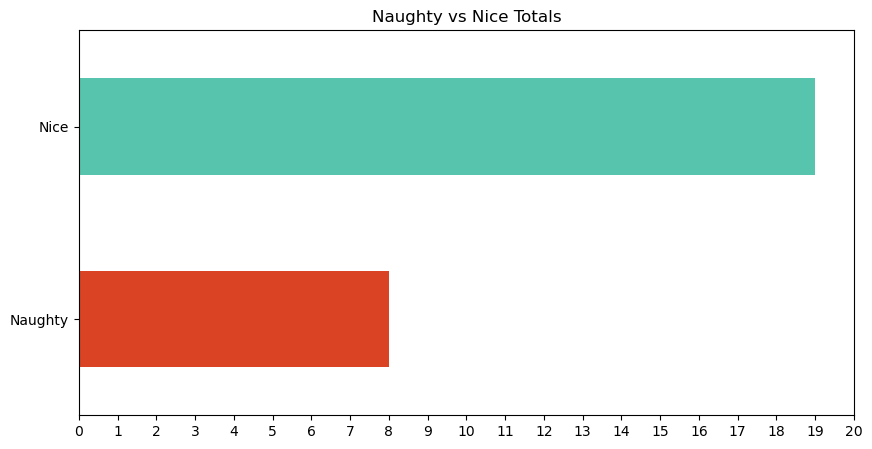

In [12]:
color_dict = {'Naughty': '#DB4325', 'Nice': '#57C4AD'}
df_counts = df['result'].value_counts().sort_values()
c = df_counts.index.map(color_dict)
ticks = np.arange(0, 21, step=1)
df_counts.plot(kind='barh', color=c, title='Naughty vs Nice Totals', figsize=(10,5), xticks=ticks);